In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

all_files = glob.glob("roll_data/*-strikes.csv")

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [2]:
def calc_vibes(df, prefix):
    buoy = df[prefix + "_buoyancy"]# * df[prefix + "_mul"]
    press = df[prefix + "_pressurization"]# * df[prefix + "_mul"]
    cinn = df[prefix + "_cinnamon"]# * df[prefix + "_mul"]

    freq = 6 + (buoy * 10).round()
    phase = math.pi * ((2/freq) * dfc["day"] + 0.5)
    vibes = 0.5 * (press + cinn) * np.sin(phase) - (0.5 * press) + (0.5 * cinn)
    return vibes

def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        pass # traveling just doesn't do anything on pitchers?
        # if not row["top_of_inning"]:
            #mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        # i messed up baserunner_count lol, so it's a string
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "GROWTH" in ptm:
        #mul += min(0.05, 0.05 * (row["day"] / 99))
        pass # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == 11:
        mul += 0.5
    return mul

def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # this doesn't seem to do anything if it's here or not here
            mul += 0.05
    if "GROWTH" in btm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == 18 and str(row["baserunner_count"]) != "[]":
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == 11:
        mul += 0.5
    return mul

In [3]:
df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)

df["ruth_scaled"] = df["pitcher_ruthlessness"] * df["pitcher_mul"]
df["musc_scaled"] = df["batter_musclitude"] * df["batter_mul"]

df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0

# df[df["pitcher_mul"] != 1][["pitcher_mul", "pitcher_mods", "pitching_team_mods"]].drop_duplicates()

In [38]:
df = df[(df["batting_team_hype"] == 0) & (df['pitching_team_hype'] == 0)]

df["ruth_vibes"] = df["ruth_scaled"] * df["pitcher_vibes"]
# put in our "best fit" up here in the original df, just because
df['svc_best'] = 0.30 * df["ruth_scaled"] + 0.20 * df["ballpark_forwardness"] \
                  + 0.06 * df["ruth_vibes"] + 0.10 * df["musc_scaled"]

In [34]:
# df = df[df["batter_mods"].isna() & df["pitcher_mods"].isna()]
dfc = df
# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]

for exclude_mod in ["FLINCH"]:
#     dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
#     dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc["flinch"] = dfc["batter_mods"].astype(str).str.contains(exclude_mod) & dfc["strike_count"] == 0
    dfc = dfc[((dfc["batter_mods"].astype(str).str.contains(exclude_mod)) & (dfc["strike_count"] == 0))]
#     dfc["flinch"] = dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)

In [35]:
print(list(df.columns))
print(len(df))
print(len(dfc))

['Unnamed: 0', 'event_type', 'roll', 'passed', 'batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon', 'batter_multiplier', 'pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_contin

In [7]:
digest_list = ["event_type", "roll", "batter_name", "pitcher_name",
               "ruth_scaled", "pitcher_vibes", "musc_scaled",
               "ballpark_forwardness", "game_id", "play_count", "svc_best"]

In [8]:
# old weighting functions, not using these

# dfc['svc'] = 0.37847946767478163 * dfc["pitcher_ruthlessness"] + 0.30163948661504275 * dfc["ballpark_forwardness"]
# # df['svc_vibes'] = 0.3570080647613859*df["pitcher_ruthlessness"] + 0.23460353690794863*df["ballpark_forwardness"] \
# #                   + 0.06376601180181157*df["pitcher_vibes"]
# dfc['svc_vibes'] = 0.35 * dfc["pitcher_ruthlessness"] + 0.25 * dfc["ballpark_forwardness"] \
#                   + 0.05 * dfc["pitcher_vibes"]
# dfc['svc_musc'] = 0.31647362 * dfc["pitcher_ruthlessness"] + 0.20359297 * dfc["ballpark_forwardness"] \
#                   + 0.05434203 * dfc["pitcher_vibes_multiplied"] + 0.09587699 * dfc["batter_musclitude"]
# dfc['batter_strikeattr'] = dfc['batter_moxie'] * ~dfc['passed'] + dfc['batter_patheticism'] * dfc['passed']
# dfc['ruth_and_fwd'] = dfc['pitcher_ruthlessness'] - 0.5 * dfc['ballpark_forwardness']
# dfc['ruth_and_fwd'] = dfc['pitcher_ruthlessness'] - 0.5 * dfc['ballpark_forwardness']


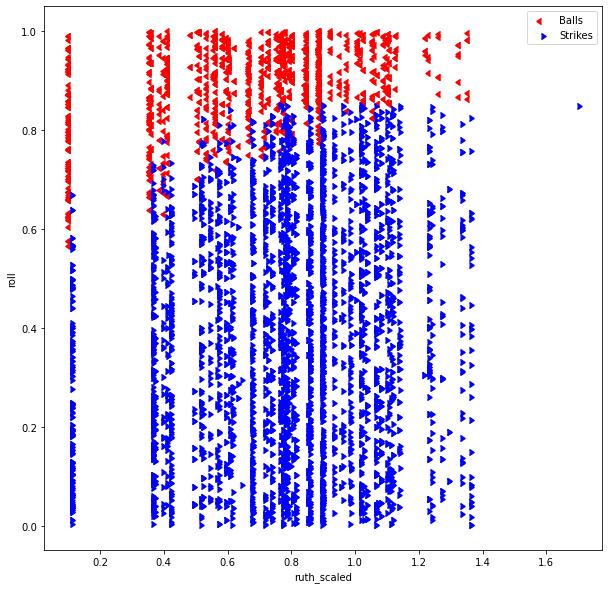

In [9]:
x_val = "ruth_scaled"
# x_val = "svc_best"
fig, ax = plt.subplots(1, figsize=(10,10))
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red", label="Balls", marker=CARETLEFTBASE)
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue", label="Strikes", marker=CARETRIGHTBASE)
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
# ax.set_xlim(0.484, 0.499)

ax.legend()

fig.savefig(x_val+".png", facecolor='white')

In [10]:
df.groupby('pitcher_ruthlessness').head(1)[['pitcher_ruthlessness', 'pitcher_name']].sort_values(
    'pitcher_ruthlessness', ascending=False)[0:20]


,pitcher_ruthlessness,pitcher_name
3689,1.356621,PolkaDot Patterson
4985,1.341412,Burke Gonzales
26,1.327721,Gabriel Griffith
61980,1.289278,Brock Forbes
81,1.236492,Theodore Cervantes
2454,1.227134,Brock Forbes
2434,1.211592,Betsy Trombone
2369,1.204338,Coolname Galvanic
4990,1.197618,Sandoval Crossing
70774,1.142962,Uncle Plasma


In [11]:
df.groupby(['batting_team_mods']).size()

batting_team_mods
AFFINITY_FOR_CROWS                                      3885
BASE_INSTINCTS                                          4136
BIRD_SEED                                               3254
BIRD_SEED;PARTY_TIME                                     736
BOTTOM_DWELLER                                          3847
BOTTOM_DWELLER;PARTY_TIME                                290
CARCINIZATION;UNHOLEY                                   4615
CARCINIZATION;UNHOLEY;PARTY_TIME                        2296
EARLBIRDS                                               2673
EARLBIRDS;PARTY_TIME                                     748
FIREPROOF;SEALANT;AMBUSH                                4023
GROWTH                                                  3938
HIGH_PRESSURE                                           3185
HIGH_PRESSURE;OVERPERFORMING                             573
LIFE_OF_PARTY;ELECTRIC                                  4187
LIFE_OF_PARTY;ELECTRIC;BOTTOM_DWELLER;BOTTOM_DWELLER     162
LIFE_O

In [12]:
# X = dfc[['roll', *df.columns[5:-11]]].drop('pitcher_name', axis=1).drop('batter_mods', axis=1)\
#     .drop('batting_team_mods', axis=1).drop('pitching_team_mods', axis=1).drop('pitcher_mods', axis=1)\
#     .drop('batter_vibes', axis=1).drop('pitcher_vibes', axis=1)\
#     .drop('batter_multiplier', axis=1).drop('pitcher_multiplier', axis=1)
# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness', 'pitcher_vibes_multiplied', 'batter_musclitude']]
X = dfc[['passed', 'roll', 'ruth_scaled', 'ballpark_forwardness', 'ruth_vibes', 'musc_scaled', 'flinch']]
X = X[X['roll'] < 0.85]

# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]
y = X['passed']
X = X.drop('passed', axis=1)

In [13]:
X

,roll,ruth_scaled,ballpark_forwardness,ruth_vibes,musc_scaled,flinch
14,0.351264,0.359045,0.532515,-0.033007,0.624909,True
30,0.356563,0.359045,0.532515,-0.033007,1.030538,True
55,0.387437,0.359045,0.532515,-0.033007,0.667068,True
78,0.692162,0.359045,0.532515,-0.033007,1.141237,True
82,0.117918,0.768336,0.560639,0.257588,0.608929,True
...,...,...,...,...,...,...
102945,0.085957,0.415525,0.405925,0.337883,0.417961,True
102950,0.627479,0.415525,0.405925,0.337883,1.418396,True
102952,0.788110,0.415525,0.405925,0.337883,0.375511,True
102953,0.449290,0.415525,0.405925,0.337883,0.375511,True


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=100000, C=1000).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y,predictionsvm))
print(classification_report(y,predictionsvm))

[[ 296    1]
 [   0 4213]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       297
        True       1.00      1.00      1.00      4213

    accuracy                           1.00      4510
   macro avg       1.00      1.00      1.00      4510
weighted avg       1.00      1.00      1.00      4510



In [15]:
sc.inverse_transform(trainedsvm.coef_)

array([[-11.52280763,   5.2985692 ,   0.61269071,   1.48474056,
          4.83559556,   1.        ]])

In [16]:
trainedsvm.coef_

array([[-48.47967642,  16.42176954,   1.70896536,   4.18916762,
          9.15217897,   0.        ]])

In [17]:
sc.scale_

array([0.2462346 , 0.27674452, 0.04733531, 0.34238438, 0.45060523,
       1.        ])

In [18]:
trainedsvm.score(X2, y)

0.9997782705099778

In [19]:
coef = np.true_divide(trainedsvm.coef_,  sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

In [20]:
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[(1.0, 'roll'),
 (-0.30139101322355805, 'ruth_scaled'),
 (-0.18337383919860797, 'ballpark_forwardness'),
 (-0.10316150114814063, 'musc_scaled'),
 (-0.0621445680028948, 'ruth_vibes'),
 (-0.0, 'flinch')]

In [21]:
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
intercept_scaled

array([-0.4063318])

In [22]:
dfc_strikes = dfc[dfc['event_type'] == "StrikeLooking"]
dfc_flinch = dfc[dfc['event_type'] == "StrikeFlinching"]
dfc_balls = dfc[dfc['event_type'] == "Ball"]

In [23]:
dfc_flinch["roll"].max()

0.8497483718665839

In [49]:
# dfc["svc_flinch"] = -1 * (\
#     coef_scaled[0,1] * dfc["ruth_scaled"] + \
#     coef_scaled[0,2] * dfc["ballpark_forwardness"] + \
#     coef_scaled[0,3] * dfc["ruth_vibes"] + \
#     coef_scaled[0,4] * dfc["musc_scaled"])
dfc["svc_flinch"] = (\
    0.30 * dfc["ruth_scaled"] + \
    0.20 * dfc["ballpark_forwardness"] + \
    0.06 * dfc["ruth_vibes"] + \
    0.10 * dfc["musc_scaled"])


,offset,home_score,away_score,top_of_inning,inning,pitcher_mul,batter_mul,baserunner_count,event_type,roll,...,pitcher_ruthlessness,batter_musclitude,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,play_count


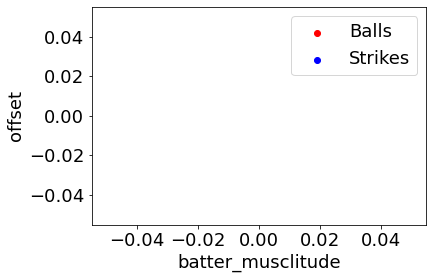

In [40]:
fwd = dfc["ballpark_forwardness"]
ruth_scaled = dfc["pitcher_ruthlessness"] * dfc["pitcher_mul"]
ruth_vibed = ruth_scaled + 0.2*(ruth_scaled * dfc["pitcher_vibes"])
musc = (dfc["batter_musclitude"] * dfc["batter_mul"])
musc_vibed = musc# * (1 - 0.005*dfc["batter_vibes"])
flinched = dfc["flinch"]
thres = 0.4 + 0.3 * ruth_vibed + 0.2 * fwd + 0.1 * musc_vibed
thres[thres > 0.85] = 0.85
dfc["threshold"] = thres
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "batter_musclitude"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["offset"], color="red", label="Balls")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["offset"], color="blue", label="Strikes")
ax.set_xlabel(x_val)
ax.set_ylabel('offset')
ax.legend()

table = outliers
table[["offset", "home_score", "away_score", "top_of_inning", "inning",
       "pitcher_mul", "batter_mul", "baserunner_count", "event_type",
       "roll", "threshold", "batter_vibes", "pitcher_vibes",
       "pitcher_ruthlessness", "batter_musclitude",
       "batter_name", "pitcher_name", "batter_mods", "pitcher_mods",
       "batting_team_mods", "pitching_team_mods", "day", "play_count"]]

0


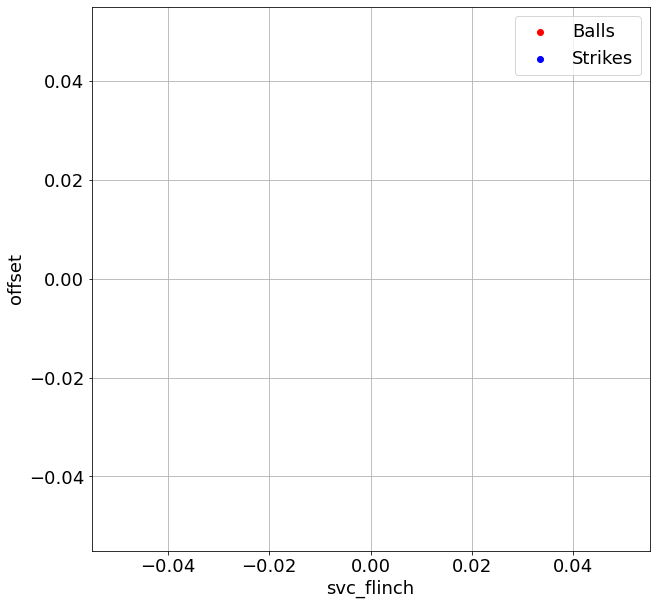

In [41]:
dfc["threshold"] = -1 * (\
    1.0 * -0.40 + \
    -0.30 * dfc["ruth_scaled"] + \
    -0.20 * dfc["ballpark_forwardness"] + \
    -0.10 * dfc["musc_scaled"] + \
    -0.06 * dfc["ruth_vibes"])
# dfc["threshold"] = -1 * (\
#     coef_scaled[0,0] * intercept_scaled + \
#     coef_scaled[0,1] * dfc["ruth_scaled"] + \
#     coef_scaled[0,2] * dfc["ballpark_forwardness"] + \
#     coef_scaled[0,3] * dfc["ruth_vibes"] + \
#     coef_scaled[0,4] * dfc["musc_scaled"] + \
#     coef_scaled[0,5] * dfc["flinch"])
dfc.loc[(dfc["threshold"] > 0.85), "threshold"] = 0.85


dfc["offset"] = dfc["roll"] - dfc["threshold"]

outliers = dfc.copy()[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
print(len(outliers))

fig, ax = plt.subplots(1)
fig.set_size_inches(10, 10)
x_val = "svc_flinch"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["offset"], color="red", label="Balls")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["offset"], color="blue", label="Strikes")
ax.set_xlabel(x_val)
ax.set_ylabel('offset')
ax.grid()
ax.legend()
# ax.set_xlim(0, 1.4)
# ax.set_xlim(0.1, 0.7)
# ax.set_ylim(-0.06, 0.08)
# fig.savefig("fit_outliers.png", facecolor='white')

In [27]:
coef_scaled[0,:]

array([ 1.        , -0.30139101, -0.18337384, -0.06214457, -0.1031615 ,
       -0.        ])

In [28]:
intercept_scaled

array([-0.4063318])

In [29]:
col_list = ['event_type',
            'roll',
            'threshold',
            'offset',
            'batter_name',
            'pitcher_name',
            'game_id',
            'play_count']#,
#             'pitcher_ruthlessness',
#             'ballpark_forwardness',
#             'pitcher_vibes_multiplied',
#             'batter_musclitude']

In [30]:
outliers.sort_values('roll', ascending=True).loc[:, col_list].style.hide()
# outliers.sort_values('offset', ascending=False).style.hide()

event_type,roll,threshold,offset,batter_name,pitcher_name,game_id,play_count


In [31]:
# df["threshold"] = \
#     0.175 * 1 + \
#     0.325 * df["pitcher_ruthlessness"] + \
#     0.2 * df["ballpark_forwardness"] + \
#     0.1 * df["batter_musclitude"] + \
#     0.05 * df["pitcher_vibes_multiplied"]
# df["threshold"] = \
#     coef_scaled[0,0] * intercept_scaled + \
#     coef_scaled[0,1] * df["pitcher_ruthlessness"] + \
#     coef_scaled[0,2] * df["ballpark_forwardness"] + \
#     coef_scaled[0,4] * df["batter_musclitude"] + \
#     coef_scaled[0,3] * df["pitcher_vibes_multiplied"]


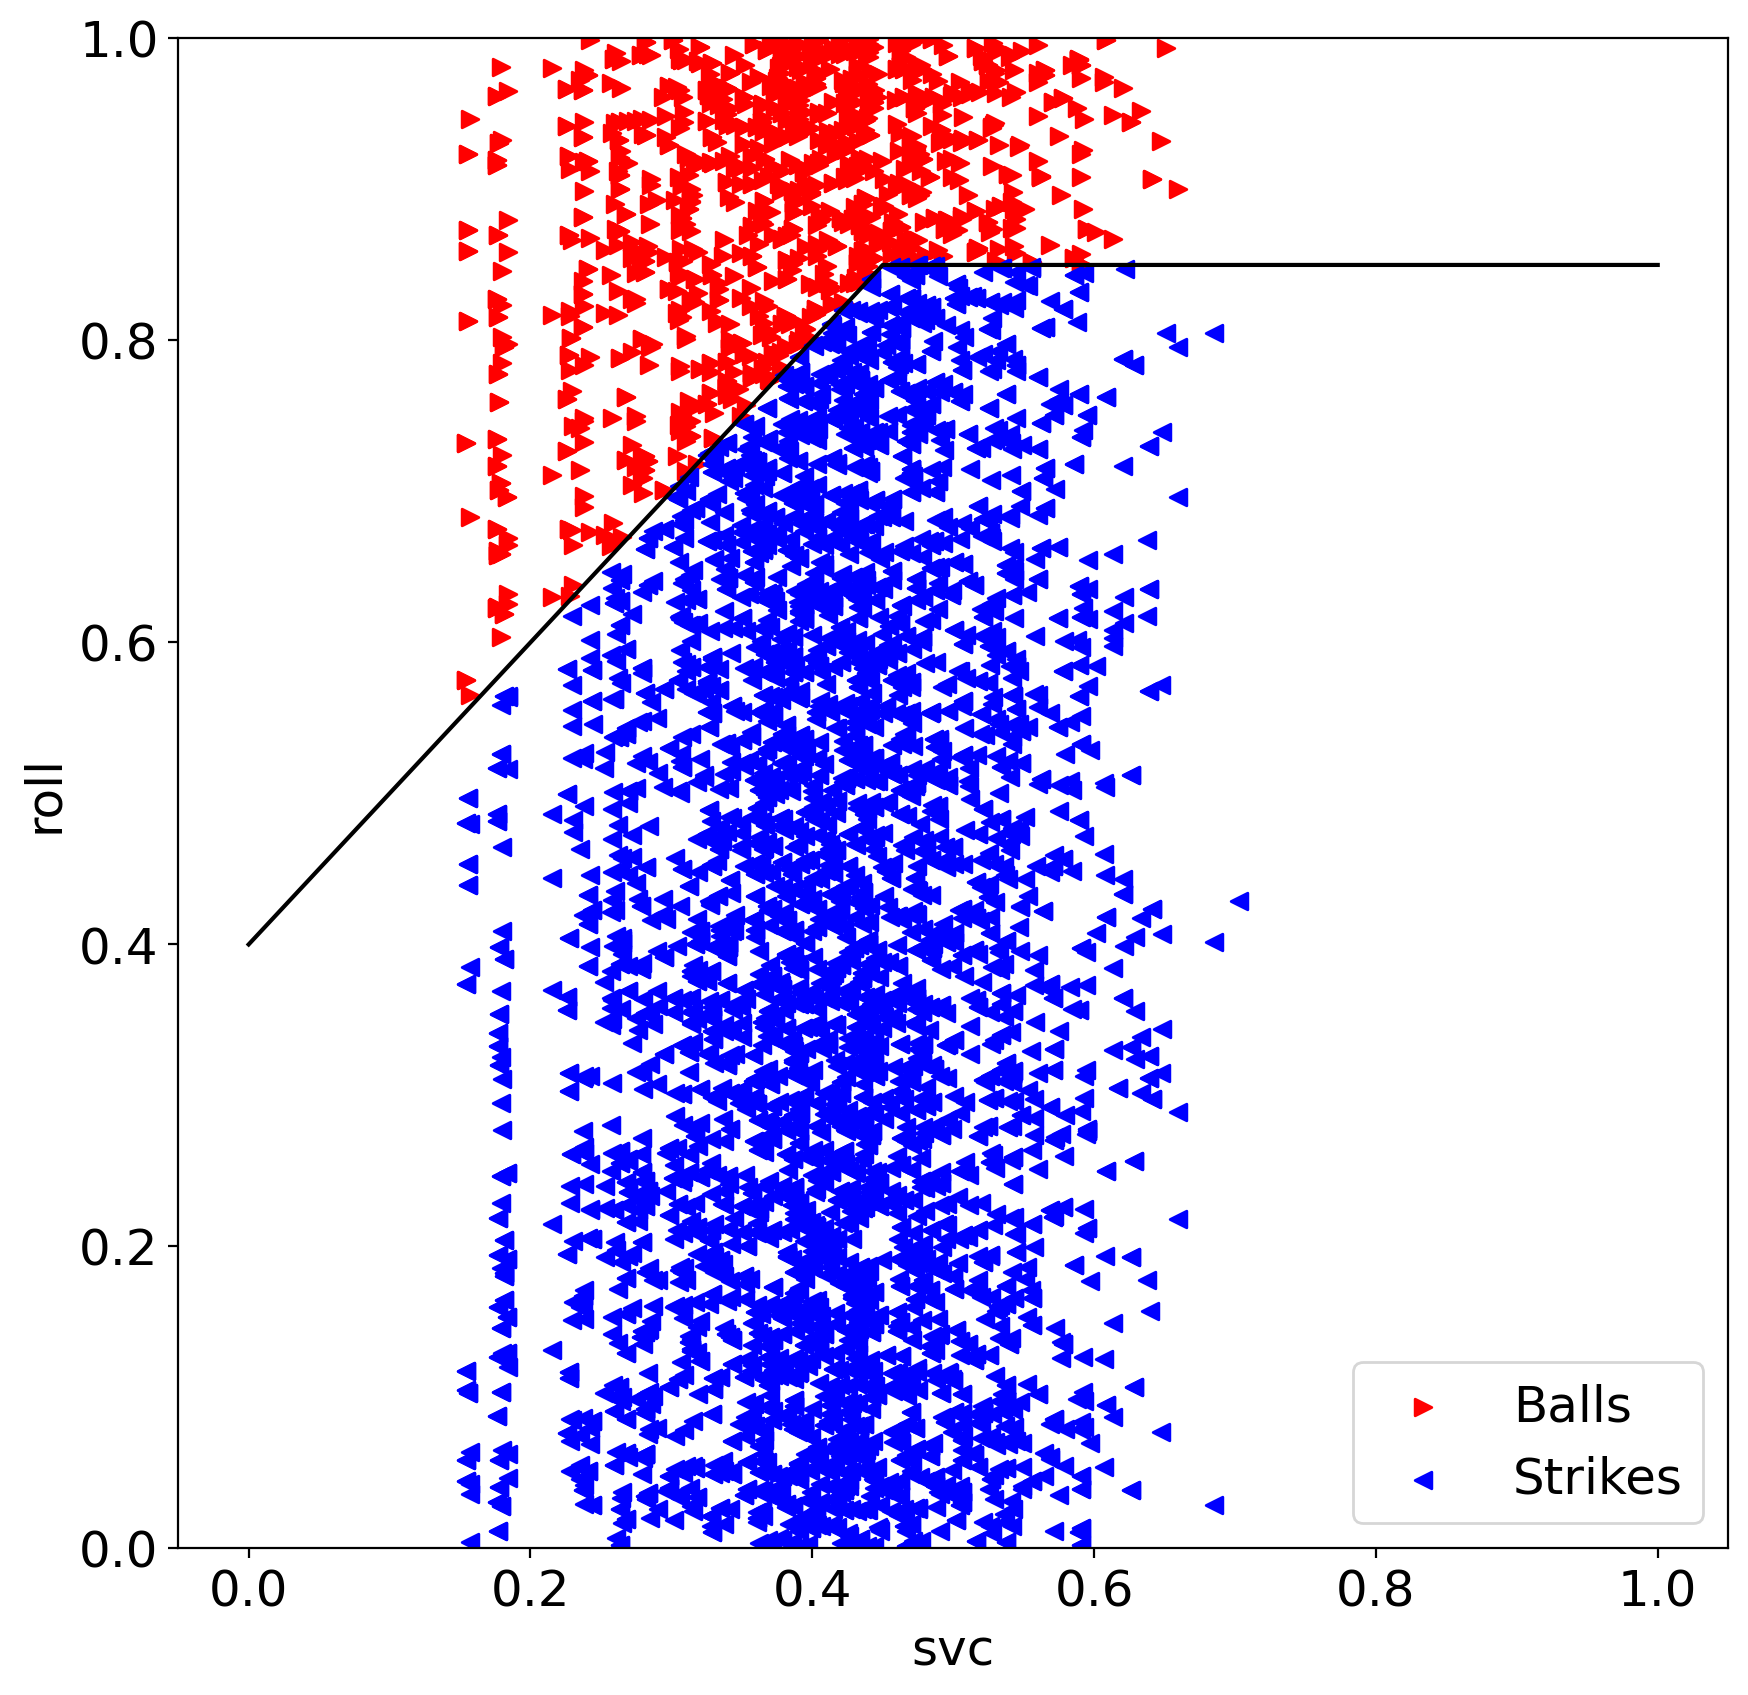

In [50]:
# x_val = "pitcher_ruthlessness"

plt.rcParams["font.size"] = 18
x_val = "svc_flinch"
fig, ax = plt.subplots(1, figsize=(10,10), dpi=200)

intercept_plot = 0.40
xline = np.array(ax.get_xlim())
xline = np.insert(xline, 1, 0.45)
yline = intercept_plot + xline
yline[(yline > 0.85)] = 0.85
# intercept_plot = intercept_scaled



# ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red", label="Balls", marker='>')
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue", label="Strikes", marker='<')
ax.plot(xline, yline, 'k')
# ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']]["roll"],
#            s=48, edgecolor='black', color="red", label="Balls (below threshold)", marker='<')
# ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']]["roll"],
#            s=48, edgecolor='black', color="blue", label="Strikes (above threshold)", marker='>')
ax.set_xlabel('svc')
ax.set_ylabel('roll')

# [(1.0, 'roll'),
#  (-0.32632849618190135, 'pitcher_ruthlessness'),
#  (-0.21512716755985498, 'ballpark_forwardness'),
#  (-0.09480214236283908, 'batter_musclitude'),
#  (-0.050859815153191414, 'pitcher_vibes_multiplied')]

ax.legend(loc='lower right')

fig.savefig("flinchtweet.png", facecolor='white', dpi=200)
# endpoints = np.array(ax.get_xlim())
# ax.plot(endpoints, 0.35 + 0.35 * endpoints)

In [33]:
outliers.groupby('pitcher_name').size()

Series([], dtype: int64)